# ARIMA

- AR: Autoregression

    - Indicates that evolving variable of interest is regressed on its own prior value.
    - It does build the regression model off of previous $y$ values:
    - $$y_t = c + \phi_1 y_{t-1}+ \phi_2 y_{t-2} + ... +  \phi_p y_{t-p} + \epsilon_t$$

        where 

        - $p$: order p
        - $\phi$: lag coefficient
        - $\epsilon_t$: white noise
        - $c$: constant
        
    
- I: Integrated
    - Indicates that data values have been replaced with the difference between their values and the previous values (differencing)
    - Just means how many times we have to difference the data to get it stationary so the AR and MA components would work together


- MA: Moving Average
    - Indicates that regression error is linear combination of errors terms, whose values occured contemporaneously and at various times into past. So it is a model that used the dependency between an observation and a residual error from a moving average model applied to lagged observations.
    - See MA with pandas, it smoothed out the values
    - We set essentially up another regression model that focuses on the residual term between a moving average and the real values<br><br>
        - $$\epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$$


Non seasonal ARIMA models are denoted ARIMA(p,d,q).
- p number of lags
- d degree of differencing
- q order of moving average model
    
    
How does ARIMA model look like? Let's see the ARMA(p,q) model first:

$$X_t - \alpha_1 X_{t-1}-...-\alpha_p X_{t-p}=\epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$$

Solve this for forecasted time component.


where:

- $X_t$ is the time series data
- $\alpha$ are the parameters of the AR model
- $\epsilon_t$ are the error terms
- $\theta$ are the parameters of the MA model

This formula can be simplified and introducing the differencing term d:

$$\left(1-\sum^p_{i=1} \phi_i L^i \right) (1-L)^d X_t = \left(1+\sum^q_{i=1} \theta_i L^i \right) \epsilon_t$$

L is considered as the lag operator.


We have to choose p, q and d. Statsmodels can help by chosing them for us!

# Choosing ARIMA Orders


- Depending on the dataset, it is common to require AR or MA only, not both
- If autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then suggest to use AR terms in relation to the lag
- If autocorrelation shows negative autocorrelation at the first lag, then it suggests using the MA term
- This means deciding what values of p, d and q to provide to the model


- Typically a sharp drop after a lag k suggest that an AR-k model order should be used
- If there is a gradual decline, it suggests using an MA model instead
- To identify an AR model it is often best done with the PACF
- To identify an MA model is often best done with the ACF rather than the PACF
- It can be difficult to read the graph, it often is better to perform a grid search across various combinations of p, d and q to find the best

## pmdarima Pyramid ARIMA

- pmdarima is a separate library designed to perform grid searches across multiple combinations of p, d and q as well as P, D and Q. pmdarima is an extension of statmodels
- Very effective way to get good fitting models.
- pmdarima uses AIC (Akaike information criterion) as a metric. AIC penalizes high order models if they do not offer an improvement over simpler models. This avoids overfitting to the training data


- $$AIC = 2 k - 2 ln(\hat{L})$$
    - k is the number of estimated parameters in the model
    - L is the likelihood function of the model

# pmdarima in Action

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


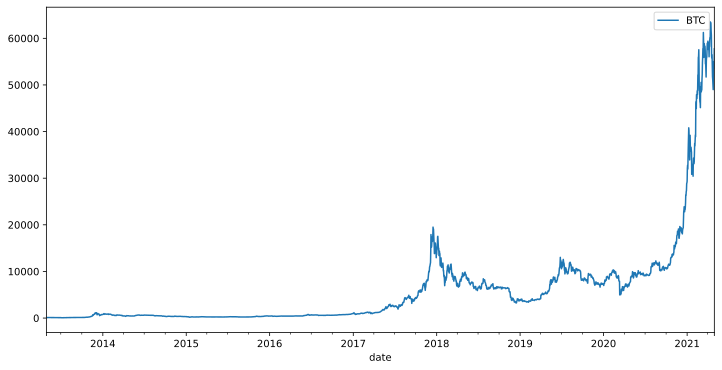

In [36]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-05-01/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_passengers.index.freq = 'MS'
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)
data_births.index.freq = 'D'

data_samples = pd.read_csv(f"{path}samples.csv", parse_dates=True, index_col=0)
data_samples.index.freq = 'MS'
data_trade = pd.read_csv(f"{path}TradeInventories.csv", parse_dates=True, index_col="Date")
data_trade.index.freq = 'MS'
data_trade

In [6]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [7]:
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


In [14]:
stepwise_fit = auto_arima(data_births['Births'], start_p=0, 
           start_q=0, 
           max_p=6, 
           max_q=3, 
           seasonal=False, 
           trace=True #trace shows first couple of models
          ) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2650.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2565.234, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2463.584, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2648.768, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2460.154, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2461.271, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2460.722, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2536.154, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2463.039, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.074, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2462.221, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2563.261, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.367, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [15]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Mon, 03 May 2021   AIC                           2459.074
Time:                        21:09:34   BIC                           2470.766
Sample:                             0   HQIC                          2463.721
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                25.33
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
stepwise_fit = auto_arima(data_passengers['Thousands of Passengers'], 
           start_p=1, 
           start_q=1,
           max_p=4, 
           max_q=4,
           start_P=0,
           D=1,
           seasonal=True, 
           trace=True, #trace shows first couple of models
           m=12
          ) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.18 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.25 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [26]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 03 May 2021   AIC                           1019.178
Time:                                     21:16:20   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARMA and Arima

In [27]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [74]:
from pmdarima.arima import auto_arima

In [75]:
df1 = data_births.iloc[0:120] # take only first 120 days
data_trade.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


## ARMA

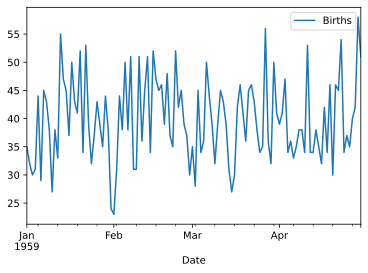

In [76]:
df1.plot(); # this dataset is stationary

Let us run ADF to confirm stationarity.

In [77]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [78]:
adf_test(series=df1['Births'], title="Birth dataset")

Augmented Dickey-Fuller Test: Birth dataset
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [79]:
auto_arima(df1['Births'],
          seasonal=False
          ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Tue, 04 May 2021   AIC                            823.489
Time:                        21:13:31   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.36   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
train = df1.iloc[:90] # first 90 days
test = df1.iloc[90:] 

In [81]:
model = ARMA(train['Births'], 
     order=(2,2) # provided by auto_arima
    )

In [82]:
results = model.fit()

In [83]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Tue, 04 May 2021   AIC                            627.809
Time:                        21:13:33   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.500      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.800      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.556      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [84]:
start = len(train)
end = len(train) + len(test) - 1 # not have indexing out of bound error

In [85]:
predictions = results.predict(start, end).rename("ARMA 2,2 Predictions")

<AxesSubplot:xlabel='Date'>

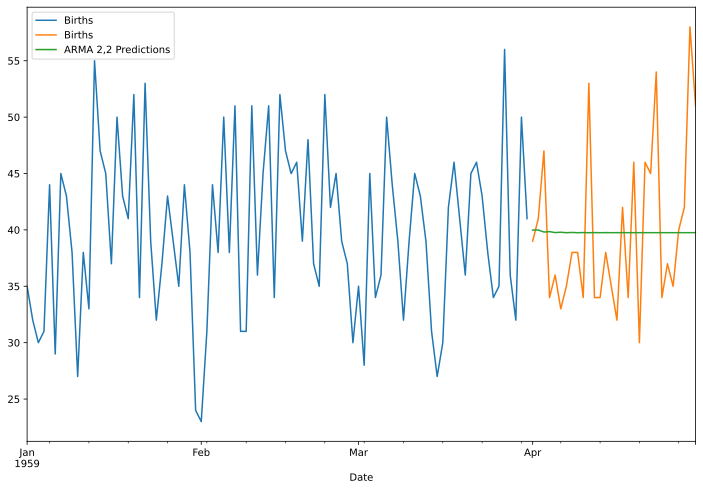

In [86]:
train['Births'].plot(figsize=(12,8), legend=True)
test['Births'].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

Because our dataset was stationary, there was not trend, the model basically just predicted the mean.

In [87]:
test.mean()


Births    39.833333
dtype: float64

In [88]:
predictions.mean()

39.777434873538205

## ARIMA

<AxesSubplot:xlabel='Date'>

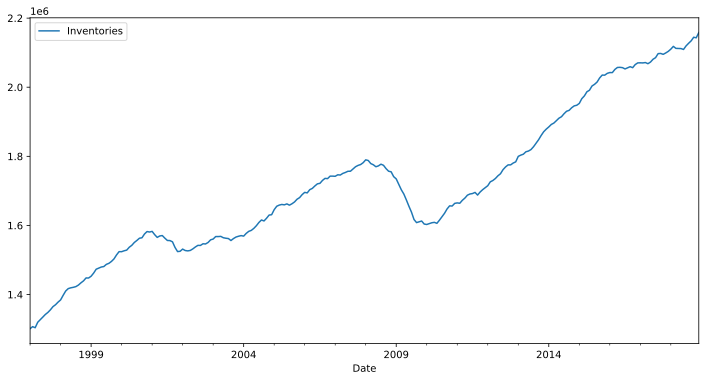

In [89]:
data_trade.plot(figsize=(12,6))

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose

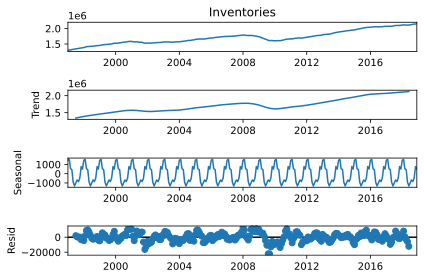

In [91]:
results = seasonal_decompose(data_trade['Inventories'], model='add')# additive model because no exponential grwowth
results.plot();

Seasonal component ranges from -1k to 1k. Observed values are orders of magnitude higher. Seasonal effects will be miniscule. One should consider not to use a seasonal model here.

In [92]:
auto_arima(data_trade['Inventories'], 
           start_p=0,
           d=0,
           start_q=0,
           seasonal=False
          ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -2642.123
Date:                Tue, 04 May 2021   AIC                           5298.247
Time:                        21:13:40   BIC                           5323.278
Sample:                             0   HQIC                          5308.305
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   7703.389      0.000       1.000       1.000
ma.L1          0.4797      0.073      6.580      0.000       0.337       0.623
ma.L2          0.3578      0.078      4.560      0.000       0.204       0.512
ma.L3          0.3591      0.073      4.941      0.000       0.217       0.502
ma.L4          0.1653      0.066      2.494      0.013       0.035       0.295
ma.L5          0.2163      0.073      2.961      0.003       0.073       0.359
sigma2      3.034e+07   6.26e-10   4.85e+16      0.000    3.03e+07    3.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.56   Prob(JB):                         0.21
Heteroskedasticity (H):               1.14   Skew:                            -0.24
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.68e+32. Standard errors may be unstable.
"""

In [98]:
adf_test(data_trade['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Let's difference the dataset.

In [99]:
from statsmodels.tsa.statespace.tools import diff

In [100]:
data_trade['Diff_1'] = diff(data_trade['Inventories'], k_diff=1)

In [101]:
adf_test(data_trade['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Let's run ACF and PACF plot to see what p and q we would pick by hand.

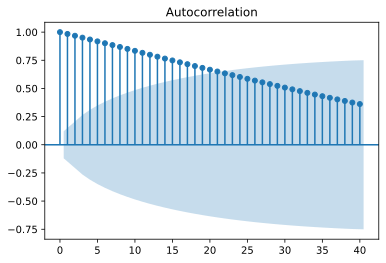

In [102]:
plot_acf(data_trade['Inventories'], lags=40);

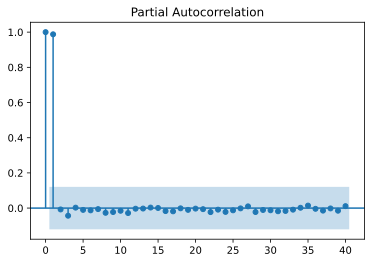

In [103]:
plot_pacf(data_trade['Inventories'], lags=40);

There are some rules (see Duke University) for what to do if the ACF and PACF exhibit certain behavior.

In [105]:
stepwise_fit = auto_arima(data_trade['Inventories'], start_p=0, start_q=0, seasonal=False, max_p=2, max_q=2, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.209 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Thu, 06 May 2021   AIC                           5348.037
Time:                        20:18:11   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
len(data_trade)

264

In [107]:
train = data_trade.iloc[:252]
test = data_trade.iloc[252:]

model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Thu, 06 May 2021   AIC                           4980.790
Time:                        20:21:07   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.869      2.378      0.017     561.674    5833.465
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [108]:
start = len(train)
end = len(train) + len(test) - 1 # not have indexing out of bound error

In [114]:
predictions = results.predict(start, end, typ='levels' # here we have a differencing term
                             ).rename("ARIMA 1,1,1 Predictions")

<AxesSubplot:xlabel='Date'>

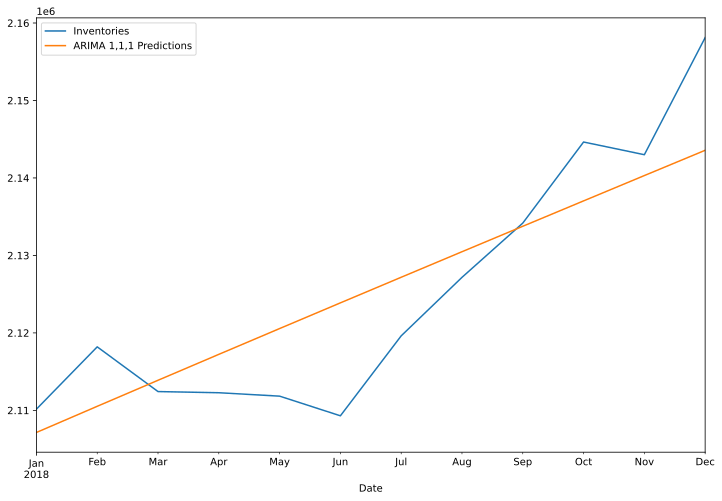

In [115]:
# train['Inventories'].plot(figsize=(12,8), legend=True)
test['Inventories'].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

In [116]:
from statsmodels.tools.eval_measures import rmse

In [117]:
error = rmse(test['Inventories'], predictions)

In [118]:
error

7789.5973836593785

In [119]:
test['Inventories'].mean()

2125075.6666666665

### Forecast into unknown future

<AxesSubplot:xlabel='Date'>

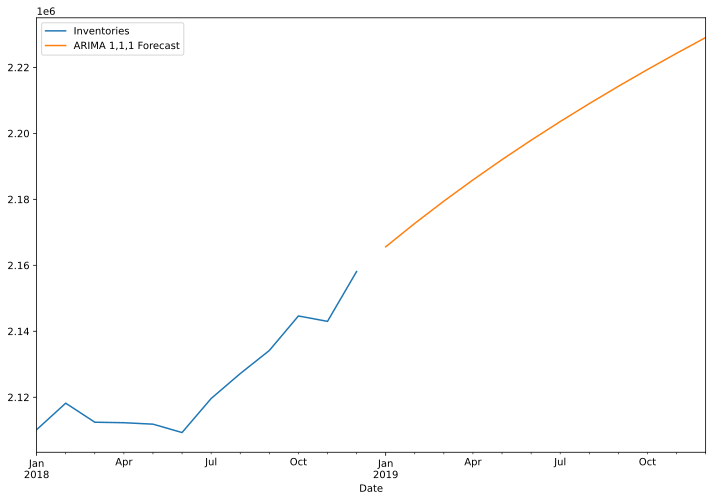

In [121]:
model = ARIMA(data_trade['Inventories'], order=(1,1,1))
results = model.fit()
fcast = results.predict(start=len(data_trade), end=len(data_trade)+11, typ='levels').rename("ARIMA 1,1,1 Forecast")
# train['Inventories'].plot(figsize=(12,8), legend=True)
test['Inventories'].plot(figsize=(12,8), legend=True)
fcast.plot(legend=True)